In [76]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import librosa

In [55]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
import pandas as pd
from pathlib import Path

download_path = Path.cwd()/'dataset'

# Read metadata file
metadata_file = download_path/'UrbanSound8K.csv'
df = pd.read_csv(metadata_file)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
# Construct file path by concatenating fold and file name
df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

# Take relevant columns
df = df[['relative_path', 'classID']]
df.head()

,relative_path,classID
0,/fold5/100032-3-0-0.wav,3
1,/fold5/100263-2-0-117.wav,2
2,/fold5/100263-2-0-121.wav,2
3,/fold5/100263-2-0-126.wav,2
4,/fold5/100263-2-0-137.wav,2


In [24]:
# Set paths to input and output data
INPUT_DIR = './dataset/'
OUTPUT_DIR = './'

In [79]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    try:
        sound_info, frame_rate = librosa.load(wav_file, sr=None)
        return sound_info, frame_rate
    except Exception as e:
        print(f"Error reading {wav_file}: {e}")
        return None, None

In [25]:
# if audio_images folder doesn't exist create it
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))

/usr/local/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


KeyboardInterrupt: 

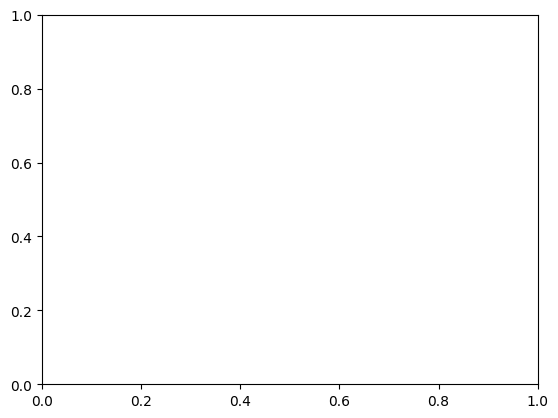

In [80]:
for foldername in os.listdir(INPUT_DIR):
    if 'fold' in foldername:
        for filename in os.listdir(INPUT_DIR+'/'+foldername):
            if 'wav' in filename:
                file_path = os.path.join(INPUT_DIR+foldername, filename)
                file_stem = Path(file_path).stem
                target_dir = f'class_{file_stem[0]}'
                dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
                file_dist_path = os.path.join(dist_dir, file_stem)
                if not os.path.exists(file_dist_path + '.png'):
                    if not os.path.exists(dist_dir):
                        os.mkdir(dist_dir)
                    file_stem = Path(file_path).stem
                    sound_info, frame_rate = get_wav_info(file_path)
                    pylab.specgram(sound_info, Fs=frame_rate)
                    pylab.savefig(f'{file_dist_path}.png')
                    pylab.close()

In [82]:
# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(9):
    print(path_list[i])
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_4
class_3
class_2
class_5
class_9
class_7
class_6
class_1
class_8

A few example files: 

172315-9-0-224.png
154758-5-0-7.png
172338-9-0-20.png
144007-5-0-20.png
185709-0-0-8.png
187356-1-4-0.png
196085-2-0-1.png
189991-0-0-1.png
159751-8-0-13.png
123688-8-1-5.png


In [90]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 3895 files belonging to 9 classes.
Using 3116 files for training.
Found 3895 files belonging to 9 classes.
Using 779 files for validation.


In [91]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

2023-07-20 18:23:40.280552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3116]
	 [[{{node Placeholder/_4}}]]
2023-07-20 18:23:40.283151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3116]
	 [[{{node Placeholder/_4}}]]


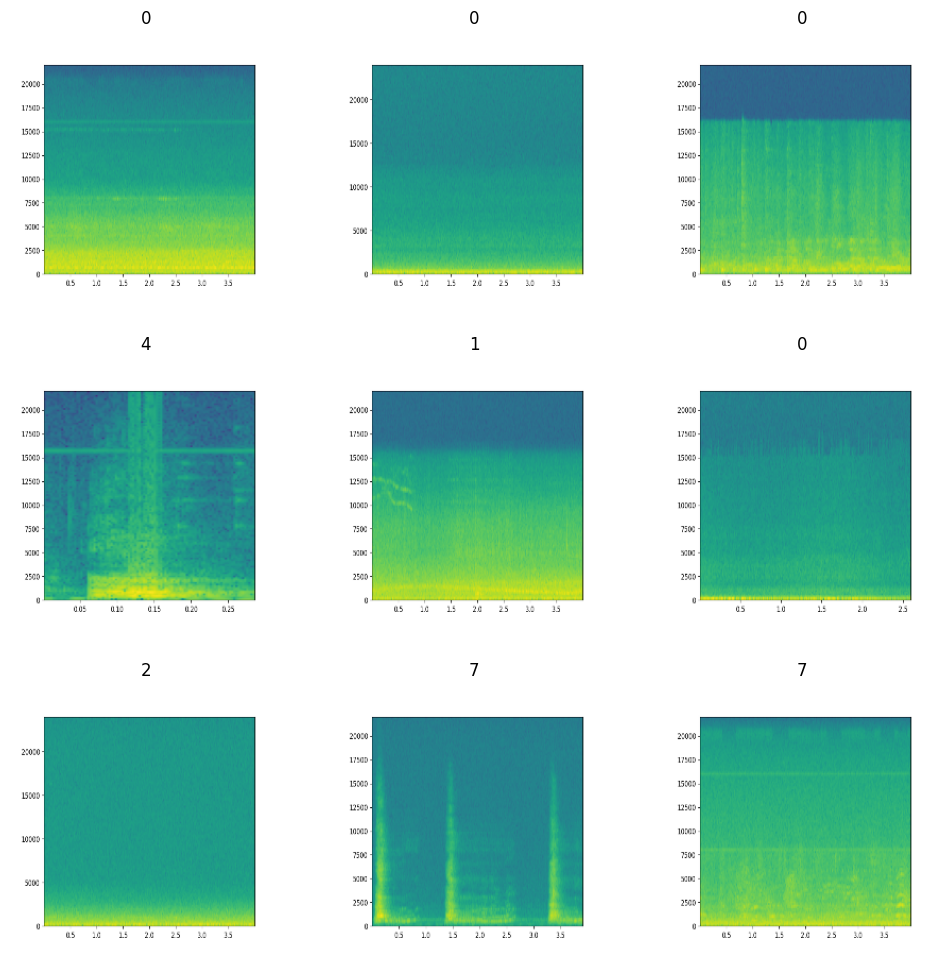

In [86]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i+1]))
        plt.axis("off")
plt.show()

In [110]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)


In [87]:
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential

In [88]:
model = Sequential()

In [92]:
model.add(Convolution2D(
        filters=32,
        activation='relu',
        kernel_size=3,
        input_shape=(256,256,3)
    ))

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [97]:
model.add(Convolution2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu',
                       ))

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [100]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.add(Flatten())

In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
Total params: 10,144
Trainable params: 10,144
Non-traina

In [103]:
model.add(Dense(units=128, activation='relu'))

In [104]:
model.add(Dense(units=128, activation='relu'))

In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [106]:
model.add(Dense(units=9 , activation='softmax'))

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [108]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [112]:
model.fit(train_dataset,epochs=10,validation_data=valid_dataset)

Epoch 1/10
98/98 [==============================] - 196s 2s/step - loss: 1.4994 - accuracy: 0.5658 - val_loss: 1.5662 - val_accuracy: 0.5892
Epoch 2/10
98/98 [==============================] - 276s 3s/step - loss: 1.4990 - accuracy: 0.5658 - val_loss: 1.5751 - val_accuracy: 0.5892
Epoch 3/10
98/98 [==============================] - 183s 2s/step - loss: 1.4990 - accuracy: 0.5658 - val_loss: 1.5647 - val_accuracy: 0.5892
Epoch 4/10
86/98 [=========================>....] - ETA: 3:41:38 - loss: 1.4952 - accuracy: 0.5698

KeyboardInterrupt: 